# Revenue Analysis of Surf and Ultimate Plans – Megaline Telecom

This notebook presents an exploratory and statistical analysis of customer data from the telecom company **Megaline**, which offers two prepaid plans: **Surf** and **Ultimate**.

The objective is to understand customer behavior (calls, messages, and internet usage) and determine which plan generates more average monthly revenue. The analysis includes data cleaning, feature engineering, revenue calculations, and statistical testing to support data-driven business decisions.

## Load all libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import math
import seaborn as sns

## Load & Explore the Data

In [2]:
# Load the data files into different DataFrames
df_calls = pd.read_csv('Datasets/megaline_calls.csv')
df_internet = pd.read_csv('Datasets/megaline_internet.csv') 
df_messages = pd.read_csv('Datasets/megaline_messages.csv')
df_plans = pd.read_csv('Datasets/megaline_plans.csv')
df_users = pd.read_csv('Datasets/megaline_users.csv')

Information about the rates DataFrame

In [3]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Don't need any modification

### Information about the users DataFrame

In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
93,1093,Karima,Hampton,69,"Nashville-Davidson–Murfreesboro–Franklin, TN MSA",2018-12-17,surf,NaN
346,1346,Emmie,Gonzalez,59,"Tucson, AZ MSA",2018-04-26,ultimate,NaN
371,1371,Roderick,Slater,27,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-10-27,surf,NaN
183,1183,Jermaine,Gallegos,71,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-07-20,surf,NaN
217,1217,Ned,Thomas,69,"Dayton-Kettering, OH MSA",2018-06-04,surf,NaN
165,1165,Nigel,Huber,20,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-27,surf,NaN
319,1319,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaN
87,1087,Lenard,Atkinson,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-11-18,surf,NaN
260,1260,Alia,Aguilar,36,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-02,surf,NaN
406,1406,Noble,Jefferson,54,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-03-04,surf,NaN


Need to chande de dates into datetime formar

Changes

In [7]:
df_users['reg_date']= pd.to_datetime(df_users['reg_date'])
df_users['churn_date']= pd.to_datetime(df_users['churn_date'])
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Enhance the dataset with additional features/information

In [8]:
df_users['is_active'] = df_users['churn_date'].isna()
df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_active
63,1063,Larhonda,Hartman,60,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-05,ultimate,NaT,True
162,1162,Mark,Farley,20,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-07-12,ultimate,NaT,True
442,1442,Terrell,Caldwell,66,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-25,ultimate,NaT,True
431,1431,Napoleon,Burt,74,"Sacramento–Roseville–Folsom, CA MSA",2018-01-28,surf,NaT,True
295,1295,Hung,Flowers,68,"Kansas City, MO-KS MSA",2018-08-11,surf,NaT,True
402,1402,Jesus,Berry,25,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-11,surf,2018-12-26,False
49,1049,Loise,Avery,25,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-21,surf,NaT,True
481,1481,Roni,Frye,32,"Urban Honolulu, HI MSA",2018-12-27,surf,NaT,True
137,1137,Allegra,Hopkins,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-10-02,surf,NaT,True
322,1322,Tyler,Sweeney,22,"Fresno, CA MSA",2018-06-18,surf,NaT,True


In [9]:
#create a new dataframe with user_id and plan
user_plan= df_users[['user_id', 'plan']]
user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


### Information about the calls DataFrame

In [10]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
df_calls.sample(10)

,id,user_id,call_date,duration
128185,1460_233,1460,2018-12-26,0.00
64573,1233_83,1233,2018-10-28,0.71
28838,1109_465,1109,2018-04-21,10.28
115072,1403_146,1403,2018-05-30,11.65
78577,1281_218,1281,2018-10-17,4.01
57819,1209_222,1209,2018-11-12,7.01
48833,1175_614,1175,2018-10-09,13.44
46668,1170_164,1170,2018-12-16,3.66
93501,1334_869,1334,2018-06-22,7.42
35451,1132_948,1132,2018-10-11,11.93


Cahnges

In [12]:
# Convert 'call_date' to datetime format
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Enhance the dataset with additional features/information

In [13]:
# Extract month from 'call_date' and create a new column
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.sample(10)

,id,user_id,call_date,duration,month
71519,1254_550,1254,2018-12-21,0.00,12
79492,1284_950,1284,2018-09-29,8.85,9
86316,1318_226,1318,2018-11-05,6.92,11
109295,1385_365,1385,2018-10-14,3.68,10
35051,1132_412,1132,2018-10-29,3.22,10
41451,1153_89,1153,2018-08-04,0.00,8
61777,1222_424,1222,2018-12-23,19.81,12
34066,1126_1057,1126,2018-09-05,0.00,9
96312,1342_60,1342,2018-12-24,2.04,12
59718,1215_103,1215,2018-09-21,0.65,9


### Information about the messages DataFrame

In [14]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
df_messages.sample(15)

,id,user_id,message_date
7915,1060_251,1060,2018-11-25
53770,1341_46,1341,2018-10-19
2528,1028_447,1028,2018-07-27
6509,1056_19,1056,2018-11-18
73017,1470_645,1470,2018-09-10
22989,1138_13,1138,2018-06-25
31653,1196_136,1196,2018-03-19
1557,1015_530,1015,2018-12-07
43620,1289_199,1289,2018-12-10
14767,1100_89,1100,2018-11-16


Changes

In [16]:
# Convert 'message_date' to datetime format
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


Enhance the dataset with additional features/information

In [17]:
# Extract month from 'message_date' and create a new column
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


### Information about the internet DataFrame

In [18]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
df_internet.sample(10)

,id,user_id,session_date,mb_used
74374,1349_103,1349,2018-10-19,116.86
93157,1434_406,1434,2018-12-21,302.90
95546,1445_194,1445,2018-05-05,223.64
46306,1206_46,1206,2018-12-17,319.02
46034,1203_359,1203,2018-09-01,585.97
89852,1414_308,1414,2018-11-14,192.49
46518,1206_420,1206,2018-09-20,0.00
70250,1328_209,1328,2018-11-23,353.96
19252,1086_41,1086,2018-12-29,621.51
31461,1144_180,1144,2018-11-06,366.00


Changes

In [20]:
# Convert 'session_date' to datetime format
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Enhance the dataset with additional features/information

In [21]:
# Extract month from 'session_date' and create a new column
df_internet['month'] = df_internet['session_date'].dt.month
df_internet

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


### Agregar datos por usuario
Now that the data is clean, aggregate the data by user and by time period so that there is only one record per user per time period. This will make further analysis much easier

In [22]:
#calculate the number of calls by month for user_id
calls_by_user = df_calls.groupby(['month', 'user_id'])['id'].count()
print(calls_by_user)

month  user_id
1      1042       18
       1077       42
       1185       23
       1196       42
       1214        5
                  ..
12     1495       65
       1496       40
       1497       54
       1498       39
       1499       65
Name: id, Length: 2258, dtype: int64


In [23]:
#calculate the total duration of calls by month and user_id
minutes_by_user = df_calls.groupby(['month', 'user_id'])['duration'].sum()
display(minutes_by_user)


month  user_id
1      1042       106.83
       1077       275.07
       1185       170.29
       1196       272.56
       1214        14.73
                   ...  
12     1495       467.47
       1496       278.61
       1497       276.53
       1498       324.77
       1499       468.10
Name: duration, Length: 2258, dtype: float64

In [24]:
#calculate the total internet usage by month for user_id
messages_by_user = df_messages.groupby(['month', 'user_id'])['id'].count()
print(messages_by_user.sample(10))


month  user_id
12     1480        51
10     1053        13
12     1464        27
4      1095         1
9      1247       109
10     1028        73
11     1198         6
12     1180        76
       1174        76
11     1341        75
Name: id, dtype: int64


In [25]:
#calculate the total internet usage by month for user_id
internet_by_user = df_internet.groupby(['month', 'user_id'])['mb_used'].sum()
print(internet_by_user)

month  user_id
1      1042        1854.93
       1077       10635.64
       1185        6812.77
       1196        8908.61
       1214        1315.35
                    ...   
12     1495       24097.40
       1496       16438.99
       1497       11106.55
       1498       23137.69
       1499       22059.21
Name: mb_used, Length: 2277, dtype: float64


Put the aggregated data together in a DataFrame so that there is one record that represents what a unique user consumed in a given month

In [26]:
#merge the calls and minutes dataframes on user_id and month
merge_1 = pd.merge(
    calls_by_user,
    minutes_by_user,
    left_index=True,
    right_index=True
)
#rename the columns for clarity
merge_1.columns = ['calls_count', 'minutes_sum']


In [27]:
#merge the internet data with the previous merge on user_id and month
merge_2 = pd.merge(
    merge_1,
    messages_by_user,
    left_index=True,
    right_index=True,
    how='left'
)
merge_2.columns = ['calls_count', 'minutes_sum', 'message_sent'] 
merge_2

calls_count  minutes_sum  message_sent
month user_id                                        
1     1042              18       106.83           NaN
      1077              42       275.07          37.0
      1185              23       170.29           NaN
      1196              42       272.56          23.0
      1214               5        14.73           2.0
...                    ...          ...           ...
12    1495              65       467.47           NaN
      1496              40       278.61          11.0
      1497              54       276.53          50.0
      1498              39       324.77           NaN
      1499              65       468.10           NaN

[2258 rows x 3 columns]

In [28]:
#merge the messages data with the previous merge on user_id and month
merge_3 = pd.merge(
    merge_2, 
    internet_by_user,
    left_index=True,
    right_index=True,
    how='left'
) 
#rename the columns for clarity

merge_3.columns = ['calls_count', 'minutes_sum', 'message_sent', 'internet_used']
merge_3

calls_count  minutes_sum  message_sent  internet_used
month user_id                                                       
1     1042              18       106.83           NaN        1854.93
      1077              42       275.07          37.0       10635.64
      1185              23       170.29           NaN        6812.77
      1196              42       272.56          23.0        8908.61
      1214               5        14.73           2.0        1315.35
...                    ...          ...           ...            ...
12    1495              65       467.47           NaN       24097.40
      1496              40       278.61          11.0       16438.99
      1497              54       276.53          50.0       11106.55
      1498              39       324.77           NaN       23137.69
      1499              65       468.10           NaN       22059.21

[2258 rows x 4 columns]

In [29]:
# Fill NaN values in 'message_sent' with 0, as it indicates no messages sent
merge_3['message_sent'] = merge_3['message_sent'].fillna(0)
# Reset the index to make it easier to work with
merge_3 = merge_3.reset_index()

merge_3

,month,user_id,calls_count,minutes_sum,message_sent,internet_used
0,1,1042,18,106.83,0.0,1854.93
1,1,1077,42,275.07,37.0,10635.64
2,1,1185,23,170.29,0.0,6812.77
3,1,1196,42,272.56,23.0,8908.61
4,1,1214,5,14.73,2.0,1315.35
...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40
2254,12,1496,40,278.61,11.0,16438.99
2255,12,1497,54,276.53,50.0,11106.55
2256,12,1498,39,324.77,0.0,23137.69


In [30]:
# add the user plan information to the merged DataFrame
merge_4 = pd.merge(
    merge_3, 
    user_plan,
     on='user_id',
    how='left'
) 
merge_4

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan
0,1,1042,18,106.83,0.0,1854.93,surf
1,1,1077,42,275.07,37.0,10635.64,ultimate
2,1,1185,23,170.29,0.0,6812.77,ultimate
3,1,1196,42,272.56,23.0,8908.61,ultimate
4,1,1214,5,14.73,2.0,1315.35,ultimate
...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf
2254,12,1496,40,278.61,11.0,16438.99,surf
2255,12,1497,54,276.53,50.0,11106.55,ultimate
2256,12,1498,39,324.77,0.0,23137.69,surf


In [31]:
#merge the plans data with the previous merge on user_id and month
merge_5 = merge_4.merge(df_plans, 
                        left_on='plan', 
                        right_on='plan_name',
                        how='left')
merge_5

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1,1042,18,106.83,0.0,1854.93,surf,50,15360,500,20,10,0.03,0.03,surf
1,1,1077,42,275.07,37.0,10635.64,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
2,1,1185,23,170.29,0.0,6812.77,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
3,1,1196,42,272.56,23.0,8908.61,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
4,1,1214,5,14.73,2.0,1315.35,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf,50,15360,500,20,10,0.03,0.03,surf
2254,12,1496,40,278.61,11.0,16438.99,surf,50,15360,500,20,10,0.03,0.03,surf
2255,12,1497,54,276.53,50.0,11106.55,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
2256,12,1498,39,324.77,0.0,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf


###  Calculate monthly revenue per user 

In [32]:
# calculate the monthly revenue for each user
def calc_monthly_revenue(row):
    # extract data usage and plan details from the row
    plan            = row['plan']  
    minutes_used    = row['minutes_sum']
    messages_used   = row['message_sent']
    mb_used         = row['internet_used']
    
    #extract the included limits and costs from the plan
    monthly_fee     = row['usd_monthly_pay']   
    min_incl        = row['minutes_included']   
    msg_incl        = row['messages_included'] 
    mb_incl         = row['mb_per_month_included'] 
    cost_per_min    = row['usd_per_minute']
    cost_per_msg    = row['usd_per_message']
    cost_per_gb     = row['usd_per_gb']

    #calculate the extra usage
    #minutes and messages: with a simple max(0, usage - included)
    extra_minutes   = max(0, minutes_used  - min_incl)
    extra_messages  = max(0, messages_used - msg_incl)
    
    # convert MB to GB for data usage
    used_gb_total   = math.ceil(mb_used / 1024.0)            
    included_gb     = mb_incl / 1024.0                       
    extra_gb        = max(0, used_gb_total - included_gb)   
    
    # costs for extra usage
    cost_extra_minutes  = extra_minutes  * cost_per_min
    cost_extra_messages = extra_messages * cost_per_msg
    cost_extra_gb       = extra_gb       * cost_per_gb
    
    # total revenue calculation
    total_revenue = monthly_fee + cost_extra_minutes + cost_extra_messages + cost_extra_gb
    return total_revenue

In [33]:
#fill NaN values in 'internet_used' with 0, as it indicates no internet usage
merge_5['internet_used'] = merge_5['internet_used'].fillna(0)

In [34]:
#apply the function to calculate monthly revenue
merge_5['monthly_revenue'] = merge_5.apply(calc_monthly_revenue, axis=1)
merge_5

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,monthly_revenue
0,1,1042,18,106.83,0.0,1854.93,surf,50,15360,500,20,10,0.03,0.03,surf,20.0
1,1,1077,42,275.07,37.0,10635.64,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
2,1,1185,23,170.29,0.0,6812.77,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
3,1,1196,42,272.56,23.0,8908.61,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
4,1,1214,5,14.73,2.0,1315.35,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf,50,15360,500,20,10,0.03,0.03,surf,110.0
2254,12,1496,40,278.61,11.0,16438.99,surf,50,15360,500,20,10,0.03,0.03,surf,40.0
2255,12,1497,54,276.53,50.0,11106.55,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
2256,12,1498,39,324.77,0.0,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf,100.0


In [35]:
#merge the user city information to the DataFrame
region_filter = df_users[['user_id', 'city' ]]
region_filter
merge_6 = merge_5.merge(region_filter,
                  on='user_id',
                  how='left'
                 )
merge_6 = merge_6[['month', 'user_id', 'plan', 'monthly_revenue', 'city']]
merge_6

,month,user_id,plan,monthly_revenue,city
0,1,1042,surf,20.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA"
1,1,1077,ultimate,70.0,"Charlotte-Concord-Gastonia, NC-SC MSA"
2,1,1185,ultimate,70.0,"Louisville/Jefferson County, KY-IN MSA"
3,1,1196,ultimate,70.0,"Los Angeles-Long Beach-Anaheim, CA MSA"
4,1,1214,ultimate,70.0,"San Francisco-Oakland-Berkeley, CA MSA"
...,...,...,...,...,...
2253,12,1495,surf,110.0,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2254,12,1496,surf,40.0,"New Orleans-Metairie, LA MSA"
2255,12,1497,ultimate,70.0,"Los Angeles-Long Beach-Anaheim, CA MSA"
2256,12,1498,surf,100.0,"New York-Newark-Jersey City, NY-NJ-PA MSA"


### Study user behavior

Calculate some useful descriptive statistics for the aggregated and merged data that show the overall picture captured by the data

### Calls

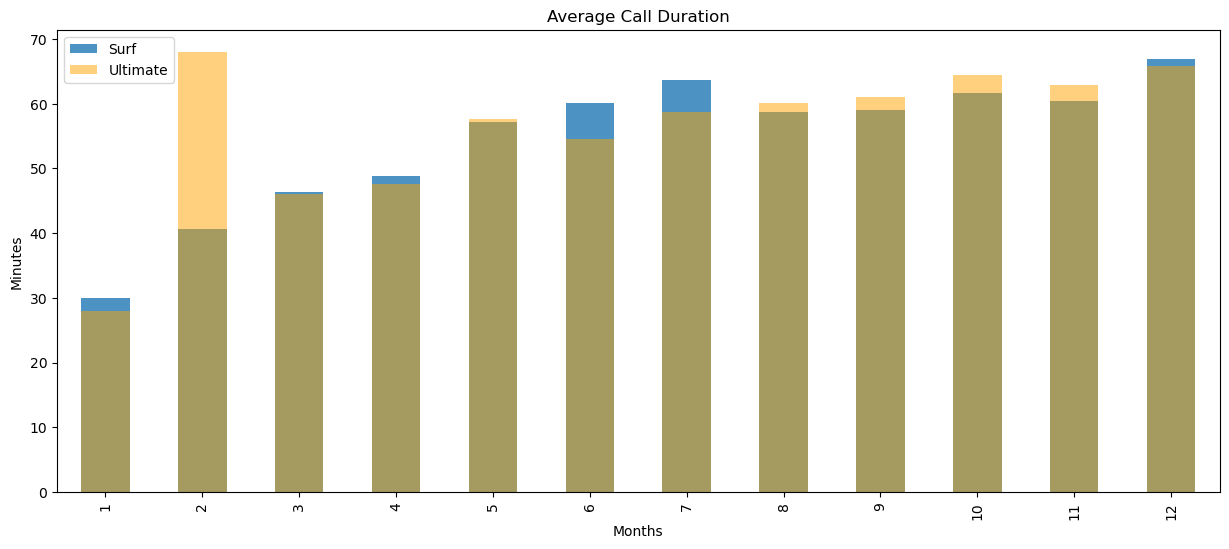

In [36]:
# Compare the average call duration for each plan
calls_df =  merge_4.groupby(['plan', 'month'])['calls_count'].mean()
#create bar plot
plt.figure(figsize=(15, 6)) 
calls_df['surf'].plot(kind='bar',
                     alpha=0.8)
calls_df['ultimate'].plot(kind='bar',
                         color='orange',
                         alpha= 0.5)
plt.xlabel('Months')
plt.ylabel('Minutes')
plt.title('Average Call Duration')
plt.legend(["Surf", "Ultimate"])

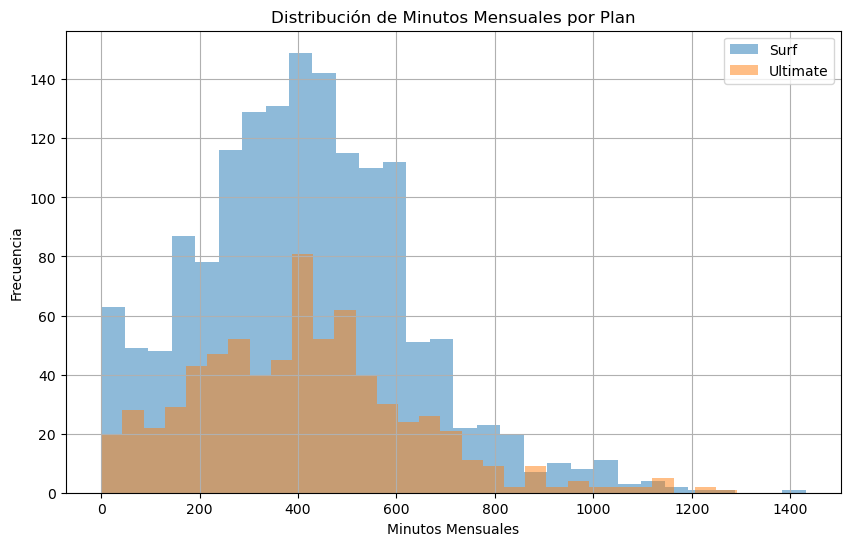

In [37]:
# Compara number of minutes used by each plan
surf_plan = merge_4[merge_4['plan'] == "surf"]
ultimate_plan = merge_4[merge_4['plan'] == "ultimate"]
plt.figure(figsize=(10, 6))

surf_plan['minutes_sum'].plot(kind='hist',
                              bins=30,
                             alpha=0.5)
ultimate_plan['minutes_sum'].plot(kind='hist',
                                  bins=30,
                                 alpha=0.5)
plt.xlabel("Minutos Mensuales")
plt.ylabel("Frecuencia")
plt.title("Distribución de Minutos Mensuales por Plan")
plt.legend(["Surf", "Ultimate"])
plt.grid(True)
plt.show()

In [38]:
# Calculate the average and variance of monthly call duration
media_llamadas = merge_4.groupby( ['month', 'plan'])['minutes_sum'].mean()
df_media = media_llamadas.to_frame().reset_index()
df_media.columns = ['month', 'plan', 'average_minutes']
variance =media_llamadas.groupby('plan').var()
variance = variance.reset_index()
print('The media of call duration by month is:\n', media_llamadas)
print('The variance of call duration is: \n', variance)

The media of call duration by month is:
 month  plan    
1      surf        192.840000
       ultimate    183.162500
2      surf        280.851111
       ultimate    443.171667
3      surf        310.970000
       ultimate    285.701667
4      surf        332.380000
       ultimate    316.508095
5      surf        387.108000
       ultimate    383.664828
6      surf        411.450625
       ultimate    365.358222
7      surf        428.060917
       ultimate    403.767288
8      surf        394.474717
       ultimate    397.274789
9      surf        397.133298
       ultimate    413.287326
10     surf        414.435733
       ultimate    429.217238
11     surf        408.255415
       ultimate    423.814683
12     surf        457.547074
       ultimate    438.824832
Name: minutes_sum, dtype: float64
The variance of call duration is: 
        plan  minutes_sum
0      surf  5636.603596
1  ultimate  5925.107084


<Figure size 1200x600 with 0 Axes>

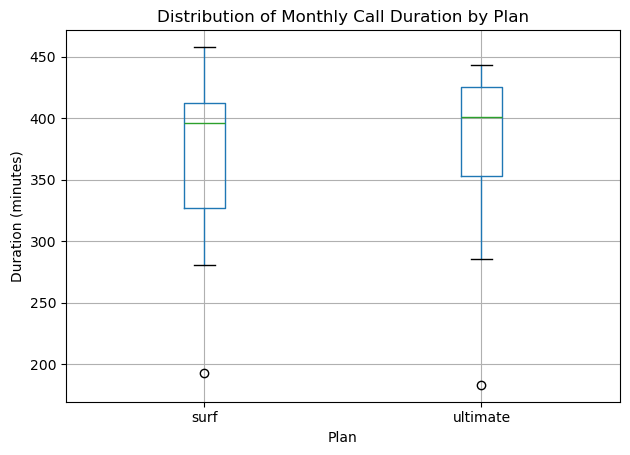

In [42]:
#boxplot for average call duration by plan
plt.figure(figsize=(12, 6))
df_media.boxplot(column='average_minutes', by='plan')
plt.title('Distribution of Monthly Call Duration by Plan')
plt.suptitle('')  
plt.xlabel('Plan')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.show()
plt.show()

The avergae call duration in the ultimate plan is higher 

### Messages

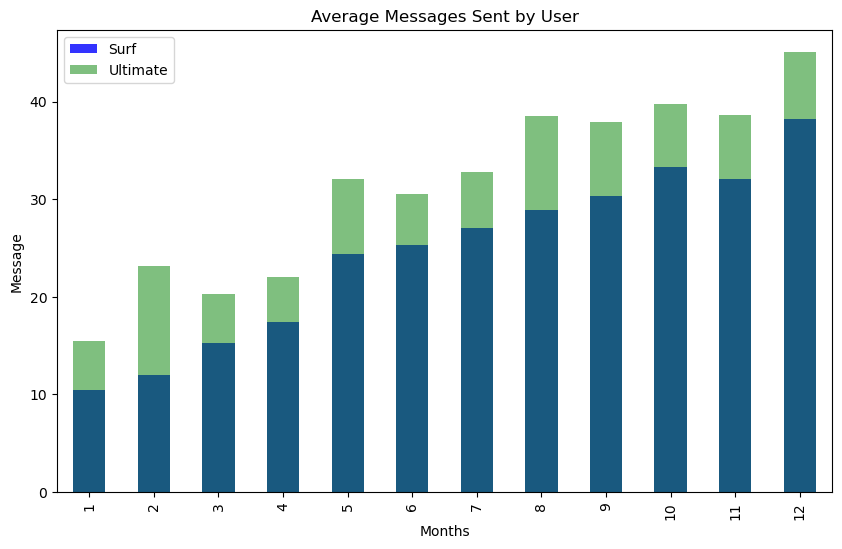

In [ ]:
# Compare the average number of messages sent by each plan
message_month = merge_4.groupby(['plan', 'month'])["message_sent"].mean()

plt.figure(figsize=(10, 6)) 
message_month['surf'].plot(kind='bar',
                           color='blue',
                     alpha=0.8)
message_month['ultimate'].plot(kind='bar',
                         color='green',
                         alpha= 0.5)
plt.xlabel('Months')
plt.ylabel('Message')
plt.title('Average Messages Sent by User')
plt.legend(["Surf", "Ultimate"])



The messages sent in the ultimate plan is visible higher in every month

### Internet

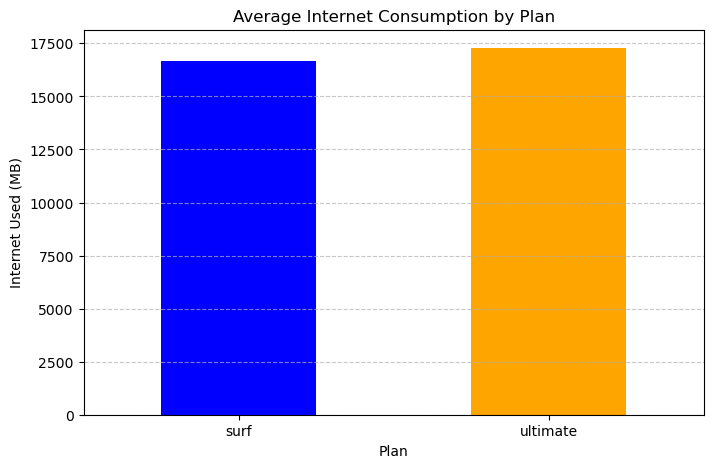

In [43]:
# Compare the average internet usage by plan
internet_usage = merge_4.groupby("plan")["internet_used"].mean()
plt.figure(figsize=(8, 5))
internet_usage.plot(kind="bar", color=["blue", "orange"])
plt.title("Average Internet Consumption by Plan")
plt.xlabel("Plan")
plt.ylabel("Internet Used (MB)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

The internet used is similar in each plan

### Income

In [44]:
plan_revenue = merge_5.groupby('plan')['monthly_revenue'].describe()
plan_revenue

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1545.0,59.739583,53.396963,20.0,20.0,40.33,80.0,588.6372
ultimate,713.0,72.277700,11.351942,70.0,70.0,70.00,70.0,182.0000


Surfers tend to pay a lot more for their rates, averaging 59, which is 39% more than the established price. Their standard deviation is 53, which means there's a high dispersion in costs, meaning there's great variability. Around 50% of the values, that is, of the users, are at 40.33, which means that half pay double the established price. The Ultimate plan is more stable; its mean is almost equal to its cost, and its standard deviation is low at 11, which means its costs are more stable and consistent. Almost all of its data is at 70. If a user is looking to pay something stable, this is the best option.

## Test statistical hypotheses

- Null hypothesis (H0): The average revenue from users of the Ultimate and Surf plans is equal.  
  H0: mean_Ultimate = mean_Surf

- Alternative hypothesis (H1): The average revenue from users of the Ultimate and Surf plans is different.  
  H1: mean_Ultimate ≠ mean_Surf


[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [49]:
# Prueba las hipótesis
surf_revenue = merge_5[merge_5['plan'] == 'surf']['monthly_revenue']  # Filtrar los ingresos del plan Surf
ultimate_revenue = merge_5[merge_5['plan'] == 'ultimate']['monthly_revenue']

print('Media income plan Surf:', surf_revenue.mean())
print('Media income plan Ultimate:', ultimate_revenue.mean())

alpha =  0.05

results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print('Valor-p:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: Average incomes are significantly different")
else:
    print("We fail to reject the null hypothesis: There is not enough evidence to claim that average incomes are different")
    


Media income plan Surf: 59.73958291262136
Media income plan Ultimate: 72.27769985974754
Valor-p: 2.8950294906188968e-18
We reject the null hypothesis: Average incomes are significantly different


- Null hypothesis (H0): The average revenue from users in the NY-NJ area is equal to the average revenue from users in other regions.  
  H0: mean_NY_NJ = mean_Other_Regions

- Alternative hypothesis (H1): The average revenue from users in the NY-NJ area is different from the average revenue from users in other regions.  
  H1: mean_NY_NJ ≠ mean_Other_Regions

In [50]:
#divide data by region
ny_filter = merge_6.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
other_filter = merge_6.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')

ny_revenue = ny_filter['monthly_revenue']
other_revenue = other_filter['monthly_revenue']

print('Media income region NY-NJ:', ny_revenue.mean())
print('Media income other regions:', other_revenue.mean())

alpha =  0.05

results = st.ttest_ind(ny_revenue, other_revenue, equal_var=False)

print('Valor-p:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: Average incomes are significantly different")
else:
    print("We cannot reject the null hypothesis: There is not enough evidence to state that average incomes are different.")


Media income region NY-NJ: 58.54780161725068
Media income other regions: 64.71140498145205
Valor-p: 0.012035021702244008
We reject the null hypothesis: Average incomes are significantly different


### Conclusión general
Users of both plans show almost similar average behavior. However, the key difference lies in the variability of their charges. A large portion of Surf plan users exceed the predefined plan limits, which results in significantly more variable revenue data. In contrast, very few Ultimate plan users go beyond the included limits, making the revenue data for that plan much more stable.

In practice, if you choose the Surf plan, it’s very likely you won’t pay the base $20 fee—instead, you may end up paying nearly double. That said, your total won’t usually reach $70. On the other hand, if you opt for the Ultimate plan, you’ll likely pay the full $70 consistently, but with much less variation from month to month compared to the Surf plan.